In [218]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
orientation = ["LEADING", "LAGGING"]

In [201]:
# Make an initial list of genes
nb_genes = 10
genome_size = 10_000
gene_length = 100
intergene = 900
interaction_dist = 2500

In [184]:
def generate_genes(nb_genes, gene_length, intergene):
    genes = []

    for gene in range(nb_genes):
        new_gene = {'pos': gene * (gene_length + intergene),
                    'orient': orientation[np.random.randint(2)],
                    'basal_expr': np.random.random()}
        genes.append(new_gene)

    return genes

In [187]:
def interaction(genes, i_1, i_2):
    # calcul de l'influence de la transcription du gène 2 sur le gène 1    
    
    if i_1 == i_2: # It's the same gene
        return 1.0
    
    
    gene_1 = genes[i_1]
    gene_2 = genes[i_2]
    
    ## On veut savoir si le gène 1 est avant le gène 2 ou après
    # Avant : -------1--2-------- ou -2---------------1-
    # Après : -------2--1-------- ou -1---------------2-
    
    if gene_1['pos'] < gene_2['pos']: # -------1--2-------- ou -1---------------2-
        if gene_2['pos'] - gene_1['pos'] < genome_size + gene_1['pos'] - gene_2['pos']: # -------1--2--------
            distance = gene_2['pos'] - gene_1['pos']
            is_before = True
        else: # -1---------------2-
            distance = genome_size + gene_1['pos'] - gene_2['pos']
            is_before = False
            
    else: # -------2--1-------- ou -2---------------1-
        if gene_1['pos'] - gene_2['pos'] < genome_size + gene_2['pos'] - gene_1['pos']: # -------2--1--------
            distance = gene_1['pos'] - gene_2['pos']
            is_before = False
        else:
            distance = genome_size + gene_2['pos'] - gene_1['pos']
            is_before = True
    
    ## Orientations relatives
    if (is_before and gene_2['orient'] == 'LEADING') or (not is_before and gene_2['orient'] == 'LAGGING'):
            sign = +1
    else:
            sign = -1
                            
    strength = max(1 - distance/interaction_dist, 0)
    
    #print(f"  Gene {i_1}: {gene_1['orient']}, gene {i_2}: {gene_2['orient']}, 1 before 2: {is_before}, sign: {sign}")
            
    return sign * strength

In [245]:
def make_inter_matrix(genes):
    inter_matrix = np.zeros((nb_genes, nb_genes))
    
    for i in range(nb_genes):
        for j in range(nb_genes):
            inter_matrix[i, j] = interaction(genes, i, j)
    
    return inter_matrix

In [236]:
def run_system(inter_matrix, init_expr, nb_steps):
    nb_genes = len(init_expr)
    temporal_expr = np.zeros((nb_genes, nb_steps))
    
    # Initial values at t = 0
    temporal_expr[:, 0] = expression_levels[:]
    
    # Iterate the system
    for t in range(1, nb_steps):
        temporal_expr[:, t] = inter_matrix @ temporal_expr[:, t-1]
        temporal_expr[:, t] = np.maximum(temporal_expr[:, t], 0)
        temporal_expr[:, t] = np.minimum(temporal_expr[:, t], 2)
        
    return temporal_expr

In [286]:
def plot_expr(temporal_expr):
    nb_genes, nb_steps = temporal_expr.shape
    
    plt.figure(figsize=(9, 6), dpi=300)
    
    for gene in range(nb_genes):
        plt.plot(temporal_expr[gene, :], label=f'Gene {gene}')
    
    plt.grid(linestyle=':')
    plt.xlabel('Time', fontsize='large')
    plt.ylabel('Expression level', fontsize='large')
    
    #plt.legend()
    
    plt.show()

In [287]:
genes = generate_genes(nb_genes, gene_length, intergene)

inter_matrix = make_inter_matrix(genes)

expression_levels = np.array([gene['basal_expr'] for gene in genes])

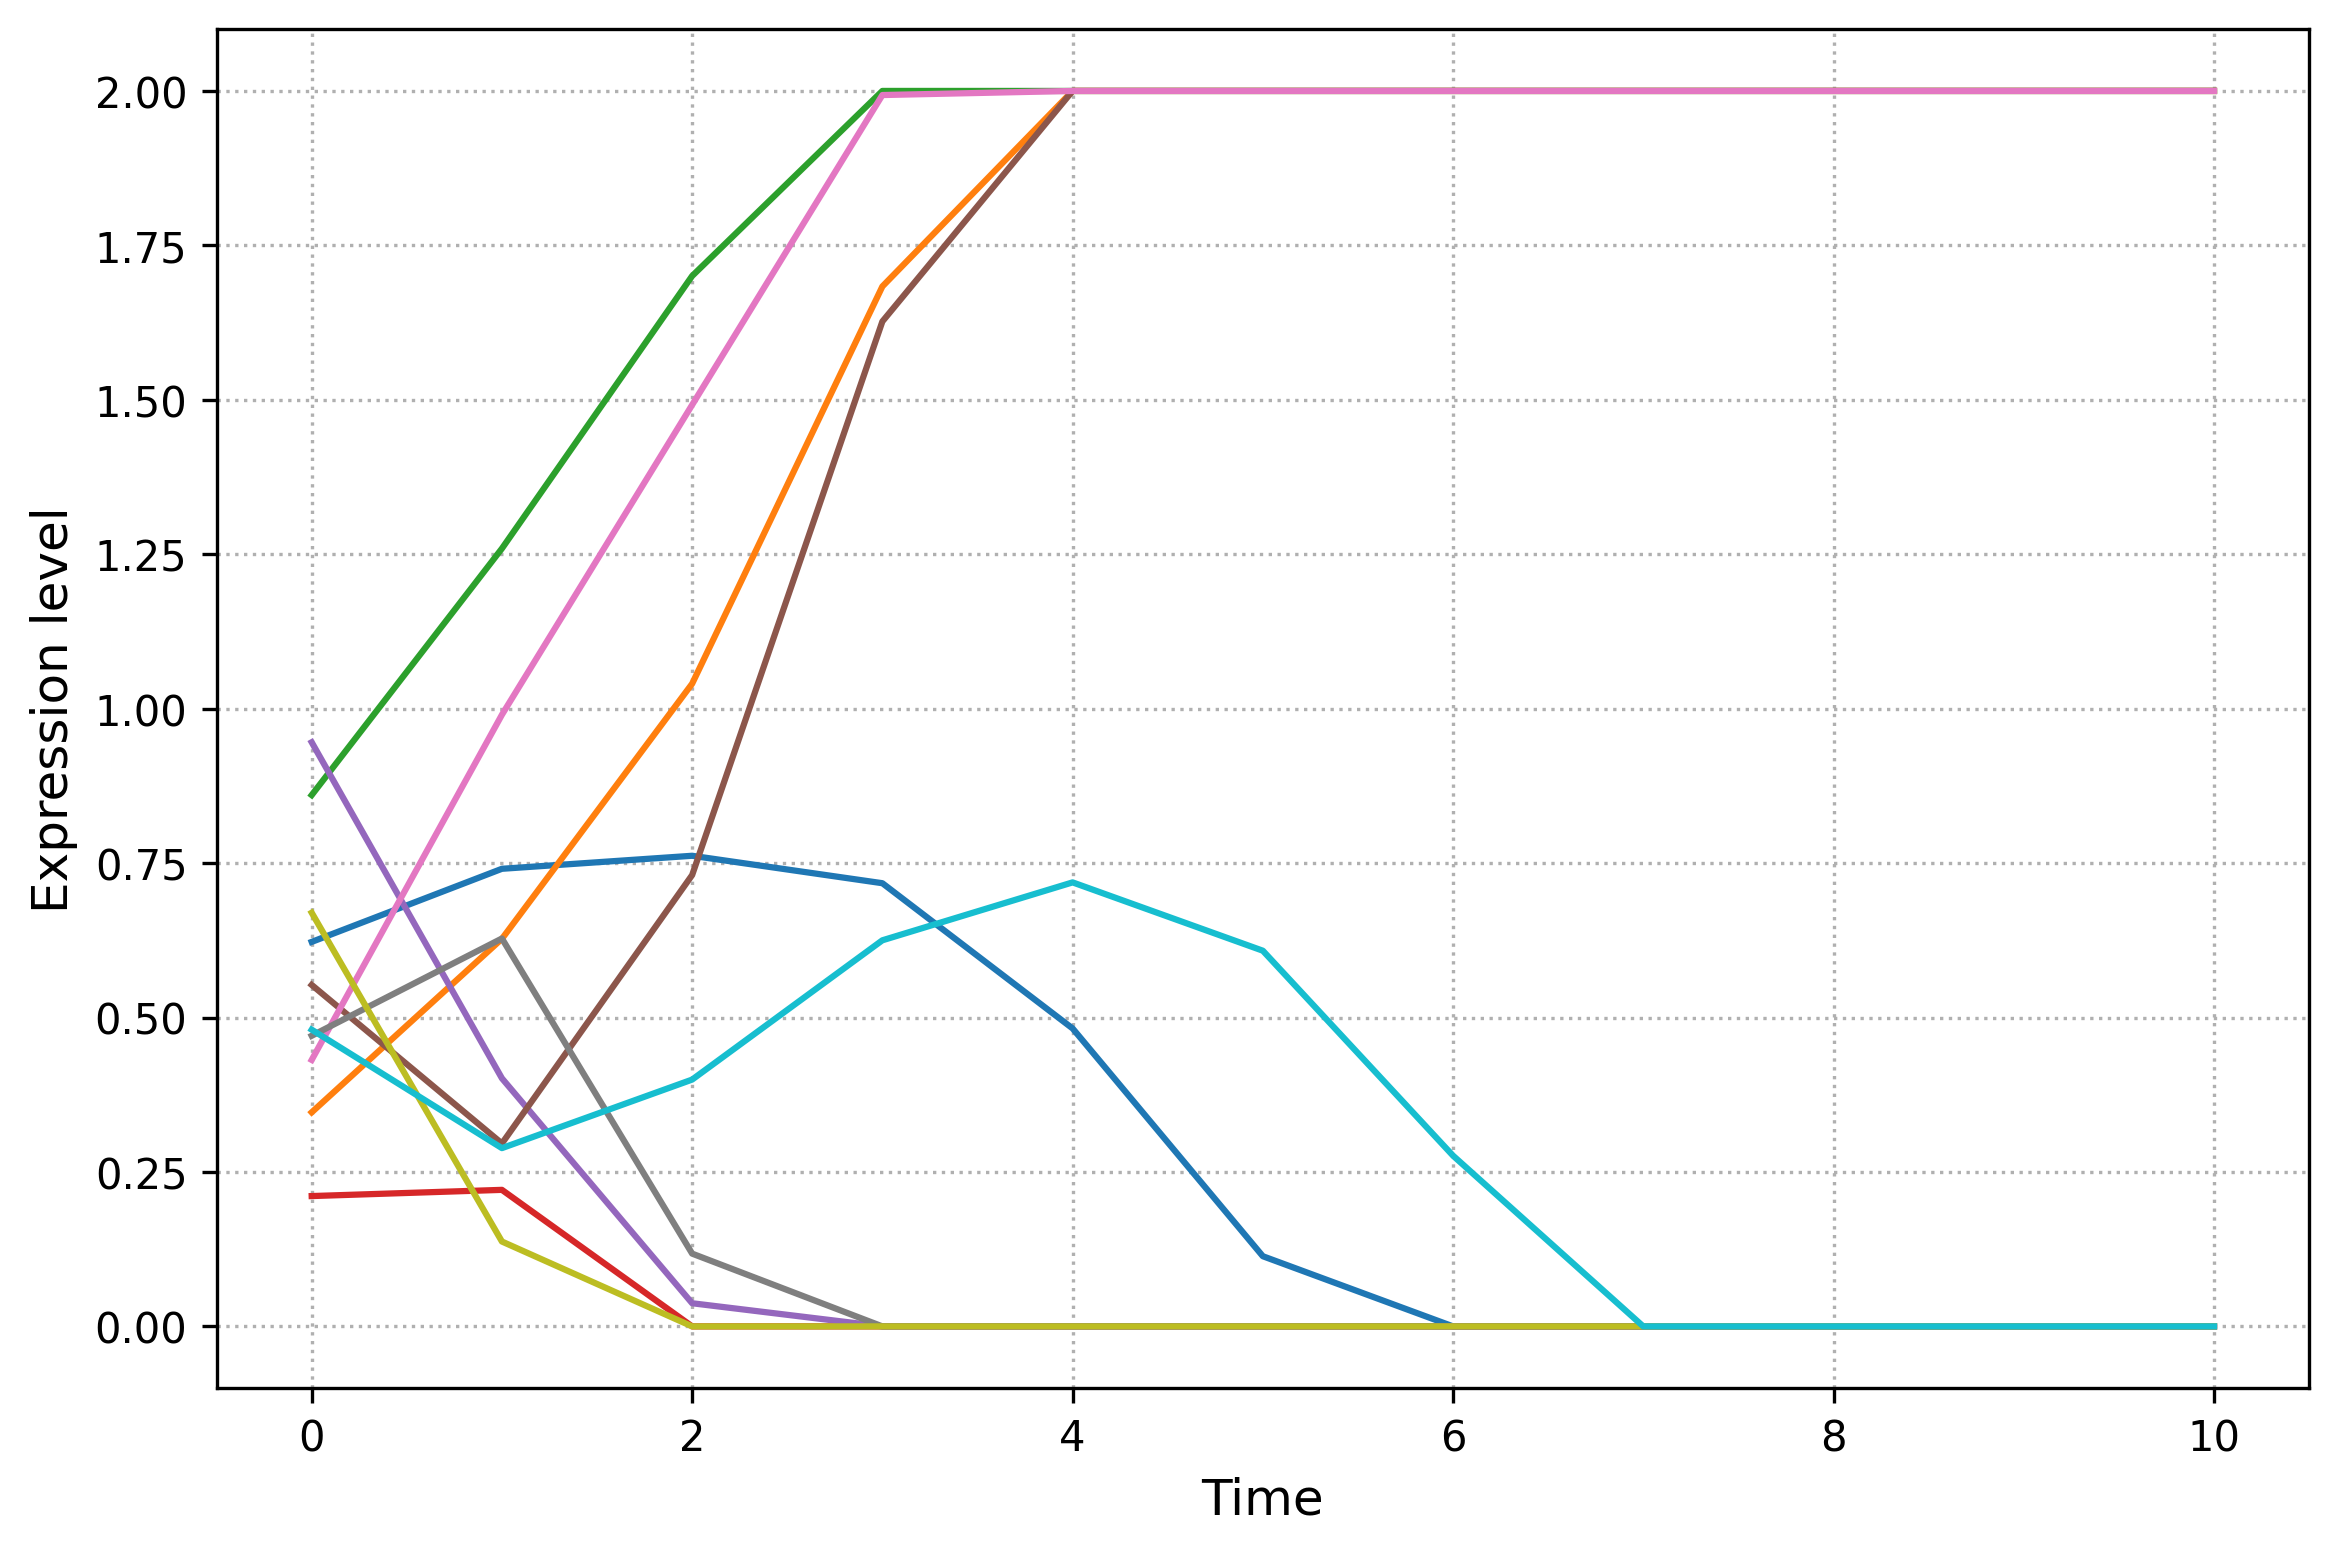

In [289]:
plot_expr(run_system(inter_matrix, expression_levels, 11))